<a class="anchor" id="0"></a>

# FE, tuning and comparison of the 20 popular models for Cardiovascular Disease prediction

Build of the 20 most popular models, the most complex models from them are tuned (optimized)

Comparison of the optimal for each type models.

This kernel is based on the my kernel "[Heart Disease - Comparison of 20 models](https://www.kaggle.com/vbmokin/heart-disease-comparison-of-20-models)"

Thanks for FE: https://www.kaggle.com/benanakca/comparison-of-classification-disease-prediction

<a class="anchor" id="0.1"></a>

## Table of Contents

1. [Import libraries](#1)
1. [Download datasets](#2)
1. [EDA](#3)
1. [Preparing to modeling](#4)
1. [Tuning models and test for all 16 features](#5)
    -  [Logistic Regression](#5.1)
    -  [Support Vector Machines](#5.2)
    -  [Linear SVC](#5.3)
    -  [k-Nearest Neighbors algorithm with GridSearchCV](#5.4)
    -  [Naive Bayes](#5.5)
    -  [Perceptron](#5.6)
    -  [Stochastic Gradient Descent](#5.7)
    -  [Decision Tree Classifier](#5.8)
    -  [Random Forests with GridSearchCV](#5.9)
    -  [XGB Classifier with HyperOpt](#5.10)
    -  [LGBM Classifier with HyperOpt](#5.11)
    -  [GradientBoostingClassifier with HyperOpt](#5.12)
    -  [RidgeClassifier](#5.13)
    -  [BaggingClassifier](#5.14)
    -  [ExtraTreesClassifier with HyperOpt](#5.15)
    -  [Neural Network 1](#5.16)
    -  [Neural Network 2](#5.17)
    -  [AdaBoost Classifier](#5.18)
    -  [VotingClassifier (hard voting)](#5.19)
    -  [VotingClassifier (soft voting) with GridSearchCV](#5.20)    
1. [Models evaluation](#6)

## 1. Import libraries <a class="anchor" id="1"></a>

[Back to Table of Contents](#0.1)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pandas as pp

# models
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import lightgbm as lgb
from lightgbm import LGBMClassifier

# NN models
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

ModuleNotFoundError: No module named 'lightgbm'

## 2. Download datasets <a class="anchor" id="2"></a>

[Back to Table of Contents](#0.1)

In [3]:
data = pd.read_csv("/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv", sep=";")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/cardiovascular-disease-dataset/cardio_train.csv'

In [4]:
# FE - thanks to: https://www.kaggle.com/benanakca/comparison-of-classification-disease-prediction
data.drop("id",axis=1,inplace=True)
data.drop_duplicates(inplace=True)
data["bmi"] = data["weight"] / (data["height"]/100)**2
out_filter = ((data["ap_hi"]>250) | (data["ap_lo"]>200))
data = data[~out_filter]
len(data)

NameError: name 'data' is not defined

In [4]:
out_filter2 = ((data["ap_hi"] < 0) | (data["ap_lo"] < 0))
data = data[~out_filter2]

In [6]:
data.head(3)

NameError: name 'data' is not defined

In [7]:
data.info()

NameError: name 'data' is not defined

## 3. EDA <a class="anchor" id="3"></a>

[Back to Table of Contents](#0.1)

This code is based on my kernel "[FE & EDA with Pandas Profiling](https://www.kaggle.com/vbmokin/fe-eda-with-pandas-profiling)"

In [8]:
pp.ProfileReport(data)

AttributeError: module 'pandas' has no attribute 'ProfileReport'

## 4. Preparing to modeling <a class="anchor" id="4"></a>

[Back to Table of Contents](#0.1)

In [8]:
target_name = 'cardio'
data_target = data[target_name]
data = data.drop([target_name], axis=1)

I split data on 30% in the test dataset, the remaining 70% - in the training dataset

In [9]:
train, test, target, target_test = train_test_split(data, data_target, test_size=0.2, random_state=0)

In [10]:
train.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,bmi
31684,21263,2,160,76.0,130,80,1,1,0,1,1,29.687500
5634,14684,2,184,70.0,120,80,1,1,0,0,1,20.675803
58675,23436,1,158,76.0,120,80,1,1,0,0,1,30.443839


In [12]:
test.head(3)

NameError: name 'test' is not defined

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55180 entries, 31684 to 69281
Data columns (total 12 columns):
age            55180 non-null int64
gender         55180 non-null int64
height         55180 non-null int64
weight         55180 non-null float64
ap_hi          55180 non-null int64
ap_lo          55180 non-null int64
cholesterol    55180 non-null int64
gluc           55180 non-null int64
smoke          55180 non-null int64
alco           55180 non-null int64
active         55180 non-null int64
bmi            55180 non-null float64
dtypes: float64(2), int64(10)
memory usage: 5.5 MB


In [9]:
test.info()

NameError: name 'test' is not defined

In [14]:
#%% split training set to validation set
Xtrain, Xval, Ztrain, Zval = train_test_split(train, target, test_size=0.2, random_state=0)

## 5. Tuning models and test for all features <a class="anchor" id="5"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

Now we are ready to train a model and predict the required solution. There are 60+ predictive modelling algorithms to choose from. We must understand the type of problem and solution requirement to narrow down to a select few models which we can evaluate. Our problem is a classification and regression problem. We want to identify relationship between output (Survived or not) with other variables or features (Gender, Age, Port...). We are also perfoming a category of machine learning which is called supervised learning as we are training our model with a given dataset. With these two criteria - Supervised Learning plus Classification and Regression, we can narrow down our choice of models to a few. These include:

- Logistic Regression
- Support Vector Machines and Linear SVC
- KNN or k-Nearest Neighbors
- Naive Bayes Classifier or Gaussian Naive Bayes
- Stochastic Gradient Descent, GradientBoostingClassifier, RidgeClassifier, BaggingClassifier
- Decision Tree Classifier, Random Forest, XGB Classifier, LGBM Classifier, ExtraTreesClassifier
- Perceptron, Neural Networks with different archictures (Deep Learning)
- VotingClassifier (hard or soft voting)

### 5.1 Logistic Regression <a class="anchor" id="5.1"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

**Logistic Regression** is a useful model to run early in the workflow. Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution. Reference [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression).

Note the confidence score generated by the model based on our training dataset.

In [15]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train, target)
acc_log = round(logreg.score(train, target) * 100, 2)
acc_log

72.4

In [16]:
acc_test_log = round(logreg.score(test, target_test) * 100, 2)
acc_test_log

72.85

We can use Logistic Regression to validate our assumptions and decisions for feature creating and completing goals. This can be done by calculating the coefficient of the features in the decision function.

Positive coefficients increase the log-odds of the response (and thus increase the probability), and negative coefficients decrease the log-odds of the response (and thus decrease the probability).

- *gluc* is highest coefficient
- *height*, *smoke* are largest numbers by absolute value.

In [17]:
coeff_df = pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
6,gluc,0.495488
3,ap_hi,0.068790
1,height,0.062470
4,ap_lo,0.045244
5,cholesterol,0.019555
0,gender,0.000135
2,weight,-0.068621
8,alco,-0.115299
7,smoke,-0.131832
9,active,-0.161073


### 5.2 Support Vector Machines <a class="anchor" id="5.2"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

**Support Vector Machines** are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training samples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new test samples to one category or the other, making it a non-probabilistic binary linear classifier. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine).

In [18]:
# Support Vector Machines

svc = SVC()
svc.fit(train, target)
acc_svc = round(svc.score(train, target) * 100, 2)
acc_svc

99.3

In [10]:
acc_test_svc = round(svc.score(test, target_test) * 100, 2)
acc_test_svc

NameError: name 'svc' is not defined

### 5.3 Linear SVC <a class="anchor" id="5.3"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

**SVC** is a similar to SVM method. Its also builds on kernel functions but is appropriate for unsupervised learning. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support-vector_machine#Support-vector_clustering_(SVC).

In [20]:
# Linear SVC

linear_svc = LinearSVC(dual=False)  # dual=False when n_samples > n_features.
linear_svc.fit(train, target)
acc_linear_svc = round(linear_svc.score(train, target) * 100, 2)
acc_linear_svc

72.13

In [21]:
acc_test_linear_svc = round(linear_svc.score(test, target_test) * 100, 2)
acc_test_linear_svc

72.75

### 5.4 k-Nearest Neighbors algorithm <a class="anchor" id="5.4"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

In pattern recognition, the **k-Nearest Neighbors algorithm** (or k-NN for short) is a non-parametric method used for classification and regression. A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). Reference [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

In [22]:
# k-Nearest Neighbors algorithm

knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid={'n_neighbors': [2, 3]}, cv=10).fit(train, target)
acc_knn = round(knn.score(train, target) * 100, 2)
print(acc_knn, knn.best_params_)

81.52 {'n_neighbors': 3}


In [23]:
acc_test_knn = round(knn.score(test, target_test) * 100, 2)
acc_test_knn

66.87

### 5.5 Naive Bayes <a class="anchor" id="5.5"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

In machine learning, **Naive Bayes classifiers** are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features) in a learning problem. Reference [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

In [24]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train, target)
acc_gaussian = round(gaussian.score(train, target) * 100, 2)
acc_gaussian

70.27

In [25]:
acc_test_gaussian = round(gaussian.score(test, target_test) * 100, 2)
acc_test_gaussian

70.26

### 5.6 Perceptron <a class="anchor" id="5.6"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

The **Perceptron** is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time. Reference [Wikipedia](https://en.wikipedia.org/wiki/Perceptron).

In [26]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(train, target)
acc_perceptron = round(perceptron.score(train, target) * 100, 2)
acc_perceptron

63.3

In [27]:
acc_test_perceptron = round(perceptron.score(test, target_test) * 100, 2)
acc_test_perceptron

62.59

### 5.7 Stochastic Gradient Descent <a class="anchor" id="5.7"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

**Stochastic gradient descent** (often abbreviated **SGD**) is an iterative method for optimizing an objective function with suitable smoothness properties (e.g. differentiable or subdifferentiable). It can be regarded as a stochastic approximation of gradient descent optimization, since it replaces the actual gradient (calculated from the entire data set) by an estimate thereof (calculated from a randomly selected subset of the data). Especially in big data applications this reduces the computational burden, achieving faster iterations in trade for a slightly lower convergence rate. Reference [Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In [28]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(train, target)
acc_sgd = round(sgd.score(train, target) * 100, 2)
acc_sgd

70.01

In [29]:
acc_test_sgd = round(sgd.score(test, target_test) * 100, 2)
acc_test_sgd

70.27

### 5.8 Decision Tree Classifier <a class="anchor" id="5.8"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

This model uses a **Decision Tree** as a predictive model which maps features (tree branches) to conclusions about the target value (tree leaves). Tree models where the target variable can take a finite set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning).

In [30]:
# Decision Tree Classifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(train, target)
acc_decision_tree = round(decision_tree.score(train, target) * 100, 2)
acc_decision_tree

99.98

In [31]:
acc_test_decision_tree = round(decision_tree.score(test, target_test) * 100, 2)
acc_test_decision_tree

64.0

### 5.9 Random Forests <a class="anchor" id="5.9"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/startupsci/titanic-data-science-solutions

**Random Forests** is one of the most popular model. Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees (n_estimators= [100, 300]) at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Reference [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).

In [32]:
# Random Forest

random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [100, 300]}, cv=5).fit(train, target)
random_forest.fit(train, target)
acc_random_forest = round(random_forest.score(train, target) * 100, 2)
print(acc_random_forest,random_forest.best_params_)

99.98 {'n_estimators': 300}


In [33]:
acc_test_random_forest = round(random_forest.score(test, target_test) * 100, 2)
acc_test_random_forest

71.56

### 5.10 XGB Classifier <a class="anchor" id="5.10"></a>

[Back to Table of Contents](#0.1)

XGBoost is an ensemble tree method that apply the principle of boosting weak learners (CARTs generally) using the gradient descent architecture. XGBoost improves upon the base Gradient Boosting Machines (GBM) framework through systems optimization and algorithmic enhancements. Reference [Towards Data Science.](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

We will tuning the hyperparameters of the XGBClassifier model using the HyperOpt and 10-fold crossvalidation

In [34]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_xgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.005),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
            'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'eval_metric': 'auc',
            'objective': 'binary:logistic',
            'booster': 'gbtree',
            'tree_method': 'exact',
            'silent': 1,
            'missing': None
        }
 
best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7340700344589577
{'booster': 'gbtree', 'colsample_bytree': 0.685, 'eta': 0.445, 'eval_metric': 'auc', 'gamma': 0.59, 'learning_rate': 0.005, 'max_depth': 4, 'min_child_weight': 3.0250000000000004, 'missing': None, 'n_estimators': 946, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.915, 'tree_method': 'exact'}
0.7320403923545642
{'booster': 'gbtree', 'colsample_bytree': 0.975, 'eta': 0.47500000000000003, 'eval_metric': 'auc', 'gamma': 0.6950000000000001, 'learning_rate': 0.0005, 'max_depth': 9, 'min_child_weight': 5.025, 'missing': None, 'n_estimators': 743, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.84, 'tree_method': 'exact'}
0.7303912604997873
{'booster': 'gbtree', 'colsample_bytree': 0.685, 'eta': 0.435, 'eval_metric': 'auc', 'gamma': 0.93, 'learning_rate': 0.0001, 'max_depth': 4, 'min_child_weight': 1.475, 'missing': None, 'n_estimators': 994, 'objective': 'binary:logistic', 'silent': 1, 'subsample': 0.805, 'tree_method': 'exact'}
0.7348131197018649


In [35]:
params = space_eval(space_xgb, best)
params

{'booster': 'gbtree',
 'colsample_bytree': 0.655,
 'eta': 0.435,
 'eval_metric': 'auc',
 'gamma': 0.985,
 'learning_rate': 0.037000000000000005,
 'max_depth': 10,
 'min_child_weight': 5.95,
 'missing': None,
 'n_estimators': 781,
 'objective': 'binary:logistic',
 'silent': 1,
 'subsample': 0.8300000000000001,
 'tree_method': 'exact'}

In [36]:
XGB_Classifier = XGBClassifier(**params)
XGB_Classifier.fit(train, target)
acc_XGB_Classifier = round(XGB_Classifier.score(train, target) * 100, 2)
acc_XGB_Classifier

80.32

In [37]:
acc_test_XGB_Classifier = round(XGB_Classifier.score(test, target_test) * 100, 2)
acc_test_XGB_Classifier

73.09

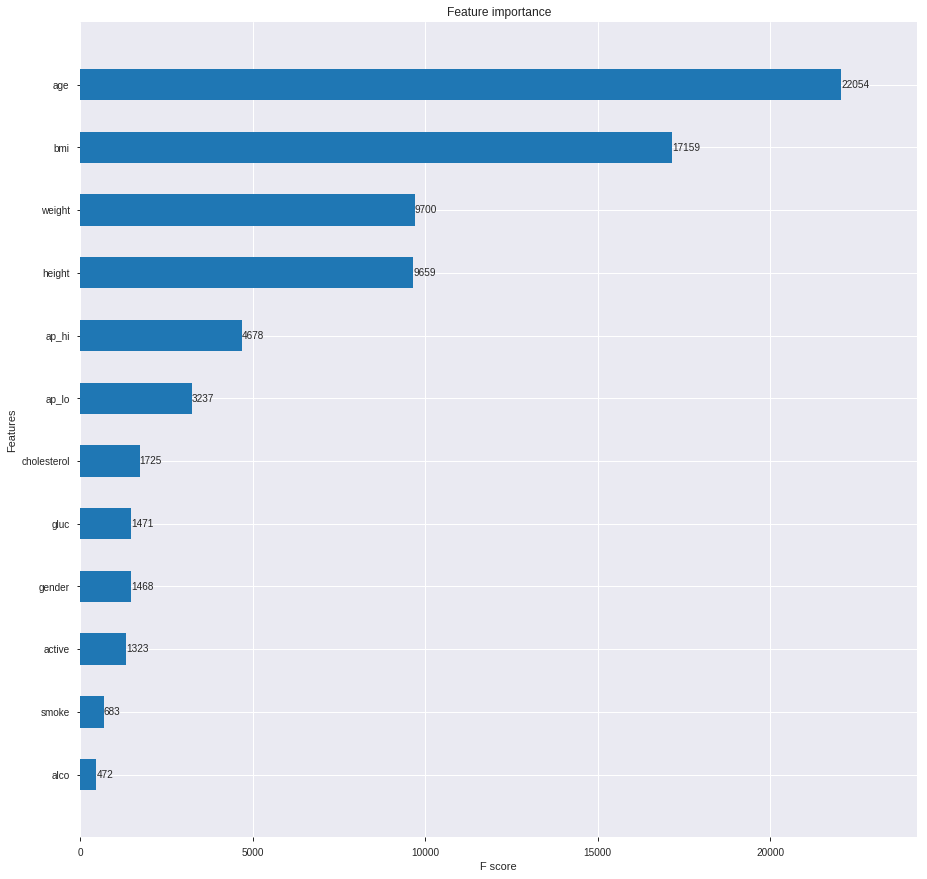

In [38]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(XGB_Classifier,ax = axes,height =0.5)
plt.show();
plt.close()

### 5.11 LGBM Classifier <a class="anchor" id="5.11"></a>

[Back to Table of Contents](#0.1)

Light GBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms. It splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’. Reference [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/).

We will tuning the hyperparameters of the LGBMClassifier model using the HyperOpt and 10-fold crossvalidation

In [39]:
def hyperopt_lgb_score(params):
    clf = LGBMClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_lgb = {
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'num_leaves': hp.choice('num_leaves', 2*np.arange(2, 2**11, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
            'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
            'objective': 'binary',
            'boosting_type': 'gbdt',
            }
 
best = fmin(fn=hyperopt_lgb_score, space=space_lgb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7322579215677917
{'boosting_type': 'gbdt', 'colsample_bytree': 0.88, 'learning_rate': 0.0143, 'max_depth': 4, 'min_child_weight': 2.7750000000000004, 'n_estimators': 128, 'num_leaves': 2690, 'objective': 'binary'}
0.7303005855742724
{'boosting_type': 'gbdt', 'colsample_bytree': 0.845, 'learning_rate': 0.020300000000000002, 'max_depth': 9, 'min_child_weight': 2.6, 'n_estimators': 975, 'num_leaves': 3168, 'objective': 'binary'}
0.7263319401540975
{'boosting_type': 'gbdt', 'colsample_bytree': 0.8, 'learning_rate': 0.0007, 'max_depth': 3, 'min_child_weight': 4.075, 'n_estimators': 942, 'num_leaves': 3410, 'objective': 'binary'}
0.7339070402569867
{'boosting_type': 'gbdt', 'colsample_bytree': 0.9, 'learning_rate': 0.0473, 'max_depth': 2, 'min_child_weight': 8.275, 'n_estimators': 663, 'num_leaves': 2316, 'objective': 'binary'}
0.7318229123950154
{'boosting_type': 'gbdt', 'colsample_bytree': 0.88, 'learning_rate': 0.0019, 'max_depth': 11, 'min_child_weight': 7.4, 'n_estimators': 477, 'num_

In [40]:
params = space_eval(space_lgb, best)
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.8,
 'learning_rate': 0.0007,
 'max_depth': 3,
 'min_child_weight': 4.075,
 'n_estimators': 942,
 'num_leaves': 3410,
 'objective': 'binary'}

In [41]:
LGB_Classifier = LGBMClassifier(**params)
LGB_Classifier.fit(train, target)
acc_LGB_Classifier = round(LGB_Classifier.score(train, target) * 100, 2)
acc_LGB_Classifier

72.71

In [42]:
acc_test_LGB_Classifier = round(LGB_Classifier.score(test, target_test) * 100, 2)
acc_test_LGB_Classifier

73.0

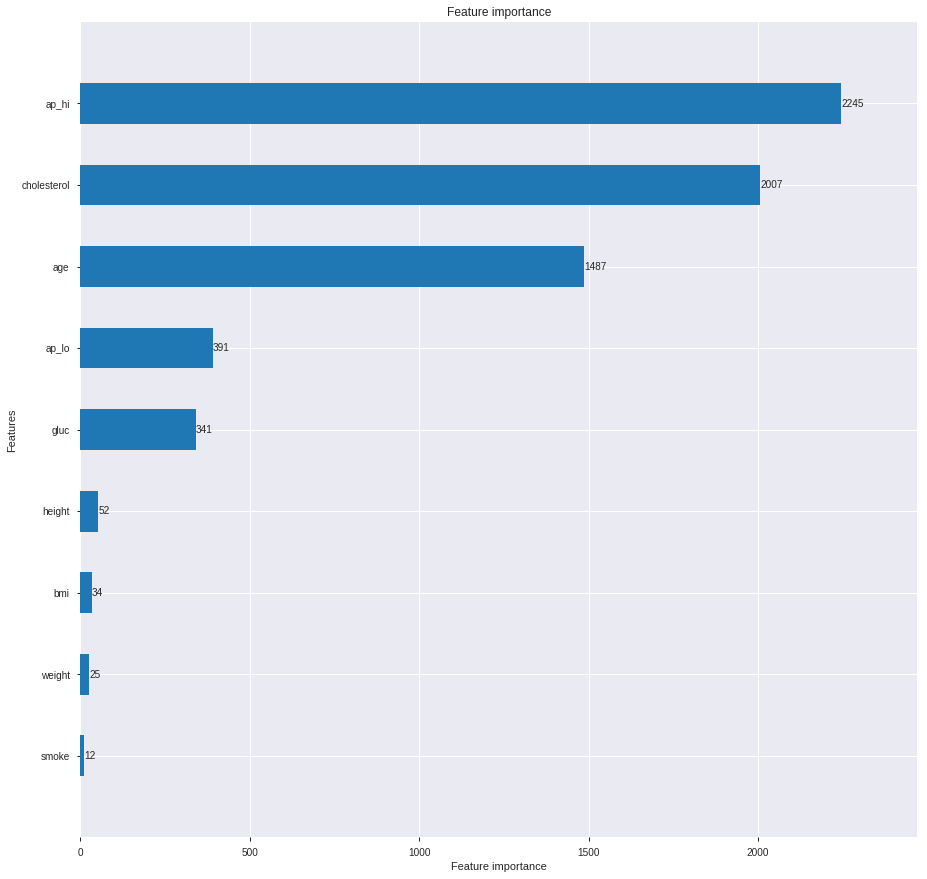

In [43]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(LGB_Classifier,ax = axes,height = 0.5)
plt.show();
plt.close()

### 5.12 GradientBoostingClassifier <a class="anchor" id="5.12"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn

**Gradient Boosting** builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage n_classes_ regression trees are fit on the negative gradient of the binomial or multinomial deviance loss function. Binary classification is a special case where only a single regression tree is induced. The features are always randomly permuted at each split. Therefore, the best found split may vary, even with the same training data and max_features=n_features, if the improvement of the criterion is identical for several splits enumerated during the search of the best split. To obtain a deterministic behaviour during fitting, random_state has to be fixed. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html).

In [44]:
def hyperopt_gb_score(params):
    clf = GradientBoostingClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_gb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_depth': hp.choice('max_depth', np.arange(2, 10, dtype=int))            
        }
 
best = fmin(fn=hyperopt_gb_score, space=space_gb, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7325840281786575
{'max_depth': 3, 'n_estimators': 560}
0.7293581790228261
{'max_depth': 4, 'n_estimators': 993}
0.7156393909742964
{'max_depth': 7, 'n_estimators': 938}
0.7334539217154489
{'max_depth': 3, 'n_estimators': 170}
0.716074262182253
{'max_depth': 8, 'n_estimators': 675}
0.7341606995406411
{'max_depth': 4, 'n_estimators': 142}
0.7095683671141932
{'max_depth': 9, 'n_estimators': 863}
0.7321309753281338
{'max_depth': 3, 'n_estimators': 663}
0.7237220953501133
{'max_depth': 8, 'n_estimators': 334}
0.7231965458960822
{'max_depth': 6, 'n_estimators': 874}
100%|██████████| 10/10 [1:37:34<00:00, 585.45s/it, best loss: 0.7095683671141932]
best:
{'max_depth': 7, 'n_estimators': 763}


In [45]:
params = space_eval(space_gb, best)
params

{'max_depth': 9, 'n_estimators': 863}

In [46]:
# Gradient Boosting Classifier

gradient_boosting = GradientBoostingClassifier(**params)
gradient_boosting.fit(train, target)
acc_gradient_boosting = round(gradient_boosting.score(train, target) * 100, 2)
acc_gradient_boosting

97.52

In [47]:
acc_test_gradient_boosting = round(gradient_boosting.score(test, target_test) * 100, 2)
acc_test_gradient_boosting

71.34

### 5.13 RidgeClassifier <a class="anchor" id="5.13"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn

Tikhonov Regularization, colloquially known as **Ridge Regression**, is the most commonly used regression algorithm to approximate an answer for an equation with no unique solution. This type of problem is very common in machine learning tasks, where the "best" solution must be chosen using limited data. If a unique solution exists, algorithm will return the optimal value. However, if multiple solutions exist, it may choose any of them. Reference [Brilliant.org](https://brilliant.org/wiki/ridge-regression/).

In [48]:
# Ridge Classifier

ridge_classifier = RidgeClassifier()
ridge_classifier.fit(train, target)
acc_ridge_classifier = round(ridge_classifier.score(train, target) * 100, 2)
acc_ridge_classifier

72.34

In [49]:
acc_test_ridge_classifier = round(ridge_classifier.score(test, target_test) * 100, 2)
acc_test_ridge_classifier

72.58

### 5.14 BaggingClassifier <a class="anchor" id="5.14"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn

Bootstrap aggregating, also called **bagging**, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. Bagging leads to "improvements for unstable procedures", which include, for example, artificial neural networks, classification and regression trees, and subset selection in linear regression. On the other hand, it can mildly degrade the performance of stable methods such as K-nearest neighbors. Reference [Wikipedia](https://en.wikipedia.org/wiki/Bootstrap_aggregating).

A **Bagging classifier** is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html).

In [50]:
# Bagging Classifier

bagging_classifier = BaggingClassifier()
bagging_classifier.fit(train, target)
Y_pred = bagging_classifier.predict(test).astype(int)
acc_bagging_classifier = round(bagging_classifier.score(train, target) * 100, 2)
acc_bagging_classifier

98.02

In [51]:
acc_test_bagging_classifier = round(bagging_classifier.score(test, target_test) * 100, 2)
acc_test_bagging_classifier

69.11

### 5.15 ExtraTreesClassifier <a class="anchor" id="5.15"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/kabure/titanic-eda-model-pipeline-keras-nn

**ExtraTreesClassifier** implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html). 

In extremely randomized trees, randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Extremely%20Randomized%20Trees).

In [52]:
def hyperopt_etc_score(params):
    clf = ExtraTreesClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_etc = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'max_features': hp.choice('max_features', np.arange(2, 17, dtype=int)),
            'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 5, dtype=int)),
            'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
            'max_features': None # for small number of features
        }
 
best = fmin(fn=hyperopt_etc_score, space=space_etc, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7333270280369352
{'max_depth': 11, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 243}
0.7332363826560091
{'max_depth': 11, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 210}
0.7201701691053877
{'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 146}
0.7323665219534164
{'max_depth': 7, 'max_features': None, 'min_samples_leaf': 2, 'n_estimators': 537}
0.7338888881840064
{'max_depth': 9, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 431}
0.7343963315624569
{'max_depth': 9, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 453}
0.7305362011682754
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 520}
0.7339975542737399
{'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 937}
0.7337982460926902
{'max_depth': 8, 'max_features': None, 'min_samples_leaf': 3, 'n_estimators': 445}
0.7316415986368441
{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 1

In [53]:
params = space_eval(space_etc, best)
params

{'max_depth': 3,
 'max_features': None,
 'min_samples_leaf': 1,
 'n_estimators': 146}

In [54]:
# Extra Trees Classifier

extra_trees_classifier = ExtraTreesClassifier(**params)
extra_trees_classifier.fit(train, target)
acc_etc = round(extra_trees_classifier.score(train, target) * 100, 2)
acc_etc

71.99

In [55]:
acc_test_etc = round(extra_trees_classifier.score(test, target_test) * 100, 2)
acc_test_etc

72.41

### 5.16 Neural Network 1 <a class="anchor" id="5.16"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/nhlr21/complete-titanic-tutorial-with-ml-nn-ensembling

**Neural networks** are more complex and more powerful algorithm than standars machine learning, it belongs to deep learning models. To build a neural network use Keras. Keras is a high level API for tensorflow, which is a tensor-manipulation framework made by google. Keras allows you to build neural networks by assembling blocks (which are the layers of neural network). 

In [56]:
def build_ann(optimizer='adam'):
    
    # Initializing the ANN
    ann = Sequential()
    
    # Adding the input layer and the first hidden layer of the ANN with dropout
    ann.add(Dense(units=32, kernel_initializer='glorot_uniform', activation='relu', input_shape=(len(train.columns),)))
    
    # Add other layers, it is not necessary to pass the shape because there is a layer before
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    ann.add(Dense(units=64, kernel_initializer='glorot_uniform', activation='relu'))
    ann.add(Dropout(rate=0.5))
    
    # Adding the output layer
    ann.add(Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid'))
    
    # Compiling the ANN
    ann.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return ann

In [57]:
opt = optimizers.Adam(lr=0.001)
ann = build_ann(opt)
# Training the ANN
history = ann.fit(Xtrain, Ztrain, batch_size=16, epochs=100, validation_data=(Xval, Zval))

Train on 44144 samples, validate on 11036 samples
Epoch 1/100
44144/44144 [==============================] - 6s 145us/step - loss: 13.8388 - accuracy: 0.5054 - val_loss: 0.6931 - val_accuracy: 0.5097
Epoch 2/100
44144/44144 [==============================] - 6s 135us/step - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 3/100
44144/44144 [==============================] - 6s 143us/step - loss: 0.6931 - accuracy: 0.5031 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 4/100
44144/44144 [==============================] - 6s 140us/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 5/100
44144/44144 [==============================] - 6s 138us/step - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 6/100
44144/44144 [==============================] - 6s 138us/step - loss: 0.6931 - accuracy: 0.5042 - val_loss: 0.6930 - val_accuracy: 0.5097
Epoch 7/100
44144/44144 [==============================

In [58]:
# Predicting the Train set results
ann_prediction = ann.predict(train)
ann_prediction = (ann_prediction > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
acc_ann1 = round(metrics.accuracy_score(target, ann_prediction) * 100, 2)
acc_ann1

50.67

In [59]:
# Predicting the Test set results
ann_prediction_test = ann.predict(test)
ann_prediction_test = (ann_prediction_test > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response and display it in confusion matrix
acc_test_ann1 = round(metrics.accuracy_score(target_test, ann_prediction_test) * 100, 2)
acc_test_ann1

49.85

### 5.17 Neural Network 2 <a class="anchor" id="5.17"></a>

[Back to Table of Contents](#0.1)

Thanks to https://www.kaggle.com/junheeshin/titanic-analyze-and-predict-nn

In [60]:
# Model
model = Sequential()
model.add(Dense(16, input_dim = train.shape[1], init = 'he_normal', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(64, init = 'he_normal', activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32, init = 'he_normal', activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 16)                208       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                1088      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 3,409
Trainable params: 3,409
Non-trainable params: 0
____________________________________________________

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, input_dim=12, activation="relu", kernel_initializer="he_normal")`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="he_normal")`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, activation="relu", kernel_initializer="he_normal")`
  import sys


In [61]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
es = EarlyStopping(monitor='val_accuracy', patience=20, mode='max')
hist = model.fit(train, target, batch_size=64, validation_data=(Xval, Zval), 
               epochs=500, verbose=1, callbacks=[es])

Train on 55180 samples, validate on 11036 samples
Epoch 1/500
55180/55180 [==============================] - 2s 40us/step - loss: 403.0773 - accuracy: 0.4978 - val_loss: 33.0397 - val_accuracy: 0.5097
Epoch 2/500
55180/55180 [==============================] - 2s 34us/step - loss: 30.6494 - accuracy: 0.4994 - val_loss: 3.8308 - val_accuracy: 0.4903
Epoch 3/500
55180/55180 [==============================] - 2s 34us/step - loss: 16.4402 - accuracy: 0.5019 - val_loss: 5.6684 - val_accuracy: 0.5097
Epoch 4/500
55180/55180 [==============================] - 2s 34us/step - loss: 9.9130 - accuracy: 0.5033 - val_loss: 10.4263 - val_accuracy: 0.4903
Epoch 5/500
55180/55180 [==============================] - 2s 34us/step - loss: 5.5726 - accuracy: 0.4988 - val_loss: 1.9496 - val_accuracy: 0.4903
Epoch 6/500
55180/55180 [==============================] - 2s 34us/step - loss: 3.1480 - accuracy: 0.5004 - val_loss: 0.7082 - val_accuracy: 0.4903
Epoch 7/500
55180/55180 [==============================]

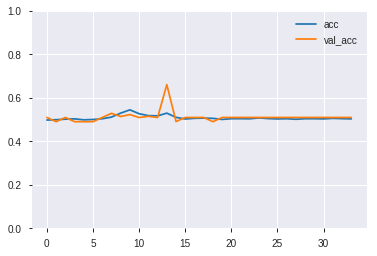

In [63]:
plt.plot(hist.history['accuracy'], label='acc')
plt.plot(hist.history['val_accuracy'], label='val_acc')
# plt.plot(hist.history['acc'], label='acc')
# plt.plot(hist.history['val_acc'], label='val_acc')
plt.ylim((0, 1))
plt.legend()

In [64]:
# Predicting the Train set results
nn_prediction = model.predict(train)
nn_prediction = (nn_prediction > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response
acc_ann2 = round(metrics.accuracy_score(target, nn_prediction) * 100, 2)
acc_ann2

50.67

In [65]:
# Predicting the Test set results
nn_prediction_test = model.predict(test)
nn_prediction_test = (nn_prediction_test > 0.5)*1 # convert probabilities to binary output

# Compute error between predicted data and true response
acc_test_ann2 = round(metrics.accuracy_score(target_test, nn_prediction_test) * 100, 2)
acc_test_ann2

49.85

### 5.18 AdaBoost Classifier <a class="anchor" id="5.18"></a>

[Back to Table of Contents](#0.1)

Thanks to https://scikit-learn.org/stable/modules/ensemble.html#adaboost

The core principle of **AdaBoost** is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying N weights to each of the training samples. Initially, those weights are all set to 1/N, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#adaboost).

In [66]:
def hyperopt_ab_score(params):
    clf = AdaBoostClassifier(**params)
    current_score = cross_val_score(clf, train, target, cv=10).mean()
    print(current_score, params)
    return current_score 
 
space_ab = {
            'n_estimators': hp.choice('n_estimators', range(50, 1000)),
            'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001)       
        }
 
best = fmin(fn=hyperopt_ab_score, space=space_ab, algo=tpe.suggest, max_evals=10)
print('best:')
print(best)

0.7278904660163688
{'learning_rate': 0.0461, 'n_estimators': 995}
0.7269299500902087
{'learning_rate': 0.043500000000000004, 'n_estimators': 575}
0.7222905846783648
{'learning_rate': 0.0102, 'n_estimators': 720}
0.7246646332621616
{'learning_rate': 0.0316, 'n_estimators': 440}
0.7123955867804359
{'learning_rate': 0.0189, 'n_estimators': 137}
0.7259513346379279
{'learning_rate': 0.0246, 'n_estimators': 806}
0.7242840737231551
{'learning_rate': 0.041600000000000005, 'n_estimators': 301}
0.7276186086897133
{'learning_rate': 0.0371, 'n_estimators': 878}
0.7279085885269045
{'learning_rate': 0.042300000000000004, 'n_estimators': 989}
0.7126130897267806
{'learning_rate': 0.0187, 'n_estimators': 141}
100%|██████████| 10/10 [40:16<00:00, 241.70s/it, best loss: 0.7123955867804359]
best:
{'learning_rate': 0.0189, 'n_estimators': 87}


In [67]:
params = space_eval(space_ab, best)
params

{'learning_rate': 0.0189, 'n_estimators': 137}

In [68]:
# AdaBoost Classifier

Ada_Boost = AdaBoostClassifier(**params)
Ada_Boost.fit(train, target)
Ada_Boost.score(train, target)
acc_AdaBoost = round(Ada_Boost.score(train, target) * 100, 2)
acc_AdaBoost

71.28

In [69]:
acc_test_AdaBoost = round(Ada_Boost.score(test, target_test) * 100, 2)
acc_test_AdaBoost

71.53

### 5.19 VotingClassifier (hard voting) <a class="anchor" id="5.19"></a>

[Back to Table of Contents](#0.1)

Thanks for the example of ensemling different models from 
https://scikit-learn.org/stable/modules/ensemble.html#Extremely%20Randomized%20Trees

The idea behind the **VotingClassifier** is to combine conceptually different machine learning classifiers and use a majority vote (hard vote) or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Voting%20Classifier).

The VotingClassifier (with **hard voting**) would classify the sample as “class 1” based on the **majority class label**. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Voting%20Classifier).

In [70]:
Voting_Classifier_hard = VotingClassifier(estimators=[('lr', logreg), ('rf', random_forest), ('ab', Ada_Boost)], voting='hard')
for clf, label in zip([logreg, random_forest, Ada_Boost, Voting_Classifier_hard], 
                      ['Logistic Regression', 'Random Forest', 'AdaBoost Classifier', 'Ensemble']):
    scores = cross_val_score(clf, train, target, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.72 (+/- 0.00) [Logistic Regression]
Accuracy: 0.71 (+/- 0.01) [Random Forest]
Accuracy: 0.71 (+/- 0.01) [AdaBoost Classifier]
Accuracy: 0.73 (+/- 0.01) [Ensemble]


In [71]:
Voting_Classifier_hard.fit(train, target)
acc_VC_hard = round(Voting_Classifier_hard.score(train, target) * 100, 2)
acc_VC_hard

77.62

In [72]:
acc_test_VC_hard = round(Voting_Classifier_hard.score(test, target_test) * 100, 2)
acc_test_VC_hard

73.16

### 5.20 VotingClassifier (soft voting) <a class="anchor" id="5.20"></a>

[Back to Table of Contents](#0.1)

Thanks for the example of ensemling different models from 
https://scikit-learn.org/stable/modules/ensemble.html#Extremely%20Randomized%20Trees

In contrast to majority voting (hard voting), **soft voting** returns the class label as argmax of the **sum of predicted probabilities**.
Specific weights can be assigned to each classifier via the weights parameter. When weights are provided, the predicted class probabilities for each classifier are collected, multiplied by the classifier weight, and averaged. The final class label is then derived from the class label with the highest average probability. Reference [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#Voting%20Classifier).

In [73]:
eclf = VotingClassifier(estimators=[('lr', logreg), ('rf', random_forest), ('ab', Ada_Boost)], voting='soft')
params = {'lr__C': [1.0, 100.0], 'ab__learning_rate': [0.0001, 1]}
Voting_Classifier_soft = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
Voting_Classifier_soft.fit(train, target)
acc_VC_soft = round(Voting_Classifier_soft.score(train, target) * 100, 2)
acc_VC_soft

83.19

In [74]:
acc_test_VC_soft = round(Voting_Classifier_soft.score(test, target_test) * 100, 2)
acc_test_VC_soft

72.87

## 6. Models evaluation <a class="anchor" id="6"></a>

[Back to Table of Contents](#0.1)

We can now rank our evaluation of all the models to choose the best one for our problem.

In [75]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Support Vector Machines', 'Linear SVC', 'k-Nearest Neighbors', 'Naive Bayes', 
              'Perceptron', 'Stochastic Gradient Decent', 
              'Decision Tree Classifier', 'Random Forest',  'XGBClassifier', 'LGBMClassifier',
              'GradientBoostingClassifier', 'RidgeClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 
              'Neural Network 1', 'Neural Network 2', 
              'VotingClassifier-hard voiting', 'VotingClassifier-soft voting',
              'AdaBoostClassifier'],
    
    'Score_train': [acc_log, acc_svc, acc_linear_svc, acc_knn, acc_gaussian, 
              acc_perceptron, acc_sgd, 
              acc_decision_tree, acc_random_forest, acc_XGB_Classifier, acc_LGB_Classifier,
              acc_gradient_boosting, acc_ridge_classifier, acc_bagging_classifier, acc_etc, 
              acc_ann1, acc_ann2, 
              acc_VC_hard, acc_VC_soft,
              acc_AdaBoost],
    'Score_test': [acc_test_log, acc_test_svc, acc_test_linear_svc, acc_test_knn, acc_test_gaussian, 
              acc_test_perceptron, acc_test_sgd, 
              acc_test_decision_tree, acc_test_random_forest, acc_test_XGB_Classifier, acc_test_LGB_Classifier,
              acc_test_gradient_boosting, acc_test_ridge_classifier, acc_test_bagging_classifier, acc_test_etc, 
              acc_test_ann1, acc_test_ann2, 
              acc_test_VC_hard, acc_test_VC_soft,
              acc_test_AdaBoost]
                    })

In [76]:
models.sort_values(by=['Score_train', 'Score_test'], ascending=False)

,Model,Score_train,Score_test
8,Random Forest,99.98,71.56
7,Decision Tree Classifier,99.98,64.00
1,Support Vector Machines,99.30,57.84
13,BaggingClassifier,98.02,69.11
11,GradientBoostingClassifier,97.52,71.34
18,VotingClassifier-soft voting,83.19,72.87
3,k-Nearest Neighbors,81.52,66.87
9,XGBClassifier,80.32,73.09
17,VotingClassifier-hard voiting,77.62,73.16
10,LGBMClassifier,72.71,73.00


In [77]:
models.sort_values(by=['Score_test', 'Score_train'], ascending=False)

,Model,Score_train,Score_test
17,VotingClassifier-hard voiting,77.62,73.16
9,XGBClassifier,80.32,73.09
10,LGBMClassifier,72.71,73.00
18,VotingClassifier-soft voting,83.19,72.87
0,Logistic Regression,72.40,72.85
2,Linear SVC,72.13,72.75
12,RidgeClassifier,72.34,72.58
14,ExtraTreesClassifier,71.99,72.41
8,Random Forest,99.98,71.56
19,AdaBoostClassifier,71.28,71.53


In [78]:
models['Score_diff'] = abs(models['Score_train'] - models['Score_test'])
models.sort_values(by=['Score_diff'], ascending=True)

,Model,Score_train,Score_test,Score_diff
4,Naive Bayes,70.27,70.26,0.01
12,RidgeClassifier,72.34,72.58,0.24
19,AdaBoostClassifier,71.28,71.53,0.25
6,Stochastic Gradient Decent,70.01,70.27,0.26
10,LGBMClassifier,72.71,73.00,0.29
14,ExtraTreesClassifier,71.99,72.41,0.42
0,Logistic Regression,72.40,72.85,0.45
2,Linear SVC,72.13,72.75,0.62
5,Perceptron,63.30,62.59,0.71
15,Neural Network 1,50.67,49.85,0.82


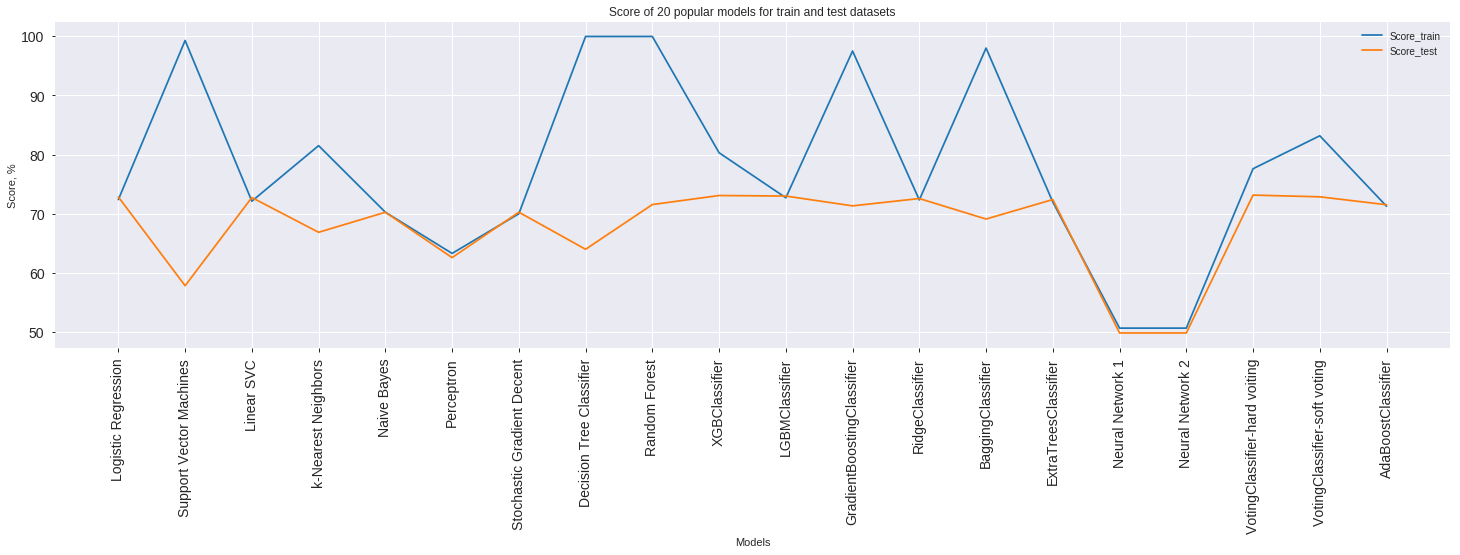

In [79]:
# Plot
plt.figure(figsize=[25,6])
xx = models['Model']
plt.tick_params(labelsize=14)
plt.plot(xx, models['Score_train'], label = 'Score_train')
plt.plot(xx, models['Score_test'], label = 'Score_test')
plt.legend()
plt.title('Score of 20 popular models for train and test datasets')
plt.xlabel('Models')
plt.ylabel('Score, %')
plt.xticks(xx, rotation='vertical')
plt.savefig('graph.png')
plt.show()

I hope you find this kernel useful and enjoyable.

Your comments and feedback are most welcome.

[Go to Top](#0)